In [117]:
import numpy as np
import matplotlib.pyplot as plt

In [118]:
dtype = np.dtype('float32')
path = "../LOFAR_2e_jaars_RP_2022_voor_studenten/Data_Pulsar1/L197621_SAP0_BEAM1_DM12.44_mask.dat"
with open( path, 'rb') as f:
    pulsar_data = np.fromfile(f, dtype)
pulsar_data

array([1354649.2, 1379855.1, 1374663.1, ..., 1479622.2, 1479622.2,
       1479622.2], dtype=float32)

In [119]:
dt = 0.00262143998406827
nbins = 69120 
total_time = nbins * dt
time = [t*dt for t in np.arange(0, nbins)]

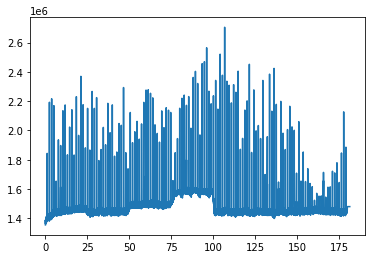

In [120]:
plt.plot(time, pulsar_data)

In [121]:
# Some utility functions.

def short_list(lst):
    """
    Returns a string that is a short representation of list lst; useful for long lists.
    """
    if len(lst) >= 4:
        return f"{lst[0]},\t{lst[1]},\t...\t,{lst[-1]},\t{lst[-2]}"
    return lst

In [122]:
def elements_containing_string(search_query, lst):
    """
    This function exists to prevent repeatingly writing the (unreadable) list
    comprehension it returns to find the elements of the list that contain the
    search_query.
    """
    return [x for x in lst if x.lower().find(search_query.strip().lower()) != -1]

In [123]:
def contains_substring(str, sub_str):
    """
    More readable syntax for checking if a string contains a substring.
    """
    return str.lower().find(sub_str.strip().lower()) != -1

In [124]:
def slice_string_at_char(str, char):
    """
    Returns a list of strings splitted on char.
    """
    return str.split(char)

In [125]:
def get_metadata_item(item):
    return slice_string_at_char(elements_containing_string(item, metadata)[0], '=')[1]

In [126]:
metadata_path = '../LOFAR_2e_jaars_RP_2022_voor_studenten/Data_Pulsar1/L197621_SAP0_BEAM1_DM12.44_Mask.inf'
with open(metadata_path) as f:
    metadata = f.readlines()

short_list(metadata)

' Data file name without suffix          =  L197621_SAP0_BEAM1_DM12.44_Mask\n,\t Telescope used                         =  LOFAR\n,\t...\t,\n,\t\n'

In [127]:
nbins = int(get_metadata_item('Number of bins in the time series'))
dt = float(get_metadata_item('Width of each time series bin (sec)'))
print(nbins)
print(dt)

69120
0.00262143998406827


In [128]:
#time_count = len(time_array) // 2 # Division by 2 will remove the sampling frequency.
#transform = np.fft.fft(signal)/ len(signal)
#print( len(transform) )
#transform = transform[range(time_count)] # Exclude sampling frequency
#print( len(transform) )

(0.0, 209.80255598842447)

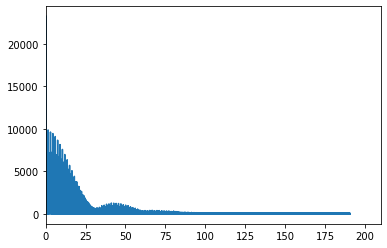

In [129]:
frequencies  = np.fft.fftfreq(nbins, dt)
transform = np.fft.fft(pulsar_data) / len(pulsar_data) # normalize the transform.
plt.plot(frequencies[1:], abs(transform[1:]))
plt.xlim(0) # to remove the symmetry from the plot.

#frequencies  = np.fft.fftfreq(nbins // 2, dt)
#transform = np.fft.fft(pulsar_data) / len(pulsar_data) # normalize the transform.
#transform = transform[ range(nbins // 2) ]
#plt.plot(frequencies[1:], abs(transform[1:]))

forget about the following calculation; we do it with fftfreq.

In [130]:
print( nbins == len(pulsar_data) )
nbins = len(pulsar_data)
total_time = dt * nbins
total_time

True


181.19393169879882

In [131]:
dnu = 1 / total_time
dnu

0.005518948623855206

Alternative calculation using built-in fftfreq of numpy. 

In [140]:
from scipy.signal import find_peaks
height_threshold = 5000 # Just reading off an apprpriate value from the graph
peaks_index, properties = find_peaks(np.abs(transform), height=height_threshold)

In [141]:
peaks_index
peak_frequencies = [frequencies[i] for i in peaks_index]
print(short_list(peak_frequencies))
print(len(peak_frequencies))

0.02759474311927603,	0.7450580642204528,	...	,-0.02759474311927603,	-0.7450580642204528
44


(0.0, 209.80255598842447)

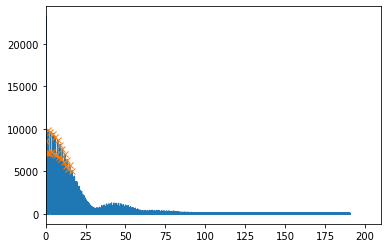

In [142]:
# Just change the height threshold above if we want less peaks to be marked.
plt.plot(frequencies[1:], np.abs(transform[1:]),'-', frequencies[peaks_index],properties['peak_heights'],'x')
plt.xlim(0)
#plt.ylim(0,10 ** 9)

In [135]:
period = 0.7450580642204528 ** -1 *1 # TODO: Automize this and make this more accurate.

## stacking

In [136]:

period_in_index = int(period // dt) # TODO: Why is this cast to int still needed?

stack_dict = dict()
i = 0
while i <= nbins:
    stack_dict[f"stack{i // period_in_index}"] = np.array( pulsar_data[i:i+period_in_index])
    i += period_in_index
len(stack_dict)

136

In [137]:
stack = np.zeros(period_in_index) # initializing with zeroes to get the correct stack size.
for key, val in stack_dict.items():
    if ( length := len(val) ) != period_in_index: # This happens at the end.
        print(f'Length of the dictionary element {key} is not {period_in_index}. Did you expect this?')
        stack += np.append(val, np.zeros(period_in_index - length )) # fill with zeroes to keep the same size.
    else:
        stack += val
len(stack) == period_in_index

Length of the dictionary element stack135 is not 512. Did you expect this?


True

Text(0.5, 1.0, 'graph of an addition of signals of the first radio pulsar ever found.')

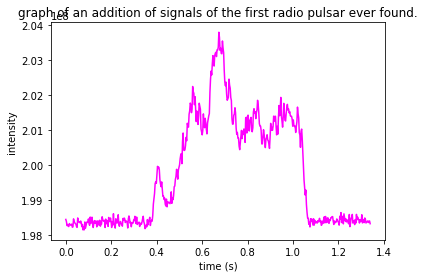

In [138]:
plt.plot([ dt * t for t in range(len(stack))], stack, color='magenta')
plt.xlabel('time (s)')
plt.ylabel('intensity')
plt.title('graph of an addition of signals of the first radio pulsar ever found.')

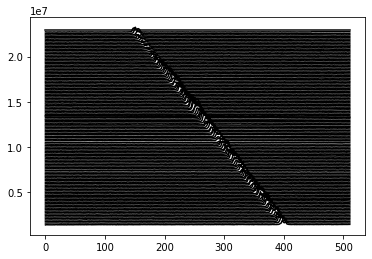

In [139]:
for i, val in enumerate ( stack_dict.values() ) :
    offset = i * 0.16 * 10 **6
    plt.plot(stack_dict[f'stack{i}'] + offset, color='black') 